In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=1

In [3]:
print FOLD

1


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True,with_l3=True,with_l4=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

In [9]:
#show_data(data,columns, 1,480, None)

In [10]:
#show_data2(data,columns)

# cv

In [11]:
n_reg_lookback=28

In [12]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'geo2_visitors_mean', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 'day_of_week_visitors_mean', 'station_count_y2', 'all_count_y5'])
len(lag_cols)

26

In [13]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [14]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                    ,
                   'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl'                   ,
                    'l3_3000_ridge_fold{}_False_d478.pkl', 'l3_3003_conv_fold{}_False_d478.pkl', 'l3_3006_xgb_fold{}_False_d478.pkl', 'l3_3001_lgb_fold{}_False_d478.pkl'
                   ])

In [15]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [16]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [17]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
print K.floatx()

Using TensorFlow backend.


float32


In [18]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [19]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [20]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[5],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 5})

In [21]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
def predict_test(self,test_gen):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X
def g(a,test_gen):
    result=predict_test(a,test_gen)
    df=pd.DataFrame({'y':result[2][:,0]})
    df['pred']=result[0][:,0]
    df['dayidx']=result[1][:,1]
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    display(df2)
    print  df2['error2'].mean()
    return  df2['error2'].mean()

PRED_DATE=478

def h(self,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, Xdict)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), 
    return yy_pred, dataidx


In [24]:
EXCLUDE_HARD=False

import rrvf_model as rrvf
import rrvf_data
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,# 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,                      
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    lag_input_dim=lag_train_test.shape[-1]
    ondate_input_dim=ondate_train_test.shape[-1]
    print lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)
    backend.clear_session()
    set_session(tf.Session(config=config))   
    a=rrvf.KerasModel("testlstm_l4_{}".format(FOLD), n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                      ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim, n_offset=n_offset,
                      max_epoch=100, use_output_exp=False,use_dropout=False,model_type='conv',
                      params=parameter)
    a._make_model()
    print a.params
    print a.model.count_params()
    a.fit(train_gen,valid_gen)
    if a.model.abnormal_stop:
        return np.inf,None,None
    valid_loss,validy,validpred,valididx=a.eval_valid()
    print valid_loss
    g(a,test_gen)
    pred478=h(a,train_gen)
    return valid_loss,(validy,valididx,validpred),pred478



def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    while 1:
        ret=_run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)
        if ret[0]<1:
            return ret
        else:
            print "bad init,try again."
        

In [25]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [26]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)    
    _,validpred,pred478=run_once(columns,data,rawy,indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds,   open('l4_3003_conv_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE) ,'wb'))



1
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 14.8043
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 372221 records
valid has 49037 records out of 372221 records
train has 5803 records out of 5803 records
no valid set
1533
0
26 36 (1, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1533/1533 [==============================] - 22s 14ms/step - loss: 0.2798 - total_loss: 0.2798 - reg_loss: 0.2798 - val_loss: 0.2620 - val_total_loss: 0.2620 - val_reg_loss: 0.2620
Epoch 2/100
1533/1533 [==============================] - 20s 13ms/step - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528 - val_loss:

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.955742 -0.026632  0.228910    7  2017-04-16
472     2.507290  2.573612 -0.066321  0.236695    1  2017-04-17
473     2.661330  2.703325 -0.041995  0.249381    2  2017-04-18
474     2.754815  2.758143 -0.003328  0.202691    3  2017-04-19
475     2.713762  2.739216 -0.025454  0.234044    4  2017-04-20
476     2.999000  3.006055 -0.007055  0.154499    5  2017-04-21
477     3.075529  3.091683 -0.016153  0.185599    6  2017-04-22

0.213116962786
best_epochs [8, 4, 6, 9, 2]
(829, 1) 2.68988747436 

2
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 14.8043
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196025, 2) (48978, 2)
train/valid # (196025, 2) (48978, 2)
rand split across time
train has 196025 records out of 372221 records
valid has 48978 records out of 372221 records
train has 6632 records out of 6632 records
no valid set
1531
0
26 36 (2, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1531/1531 [==============================] - 26s 17ms/step - loss: 0.2851 - total_loss: 0.2851 - reg_loss: 0.2851 - val_loss: 0.2814 - val_total_loss: 0.2814 - val_reg_loss: 0.2814
Epoch 2/100
1531/1531 [==============================] - 25s 17ms/step 

y      pred     error    error2  day        date
dayidx                                                         
470     2.929110  2.899334  0.029776  0.235355    6  2017-04-15
471     2.507290  2.498106  0.009184  0.235639    7  2017-04-16
472     2.661330  2.625864  0.035466  0.252899    1  2017-04-17
473     2.754815  2.724789  0.030025  0.214422    2  2017-04-18
474     2.713762  2.712509  0.001253  0.238312    3  2017-04-19
475     2.999000  2.964258  0.034742  0.158994    4  2017-04-20
476     3.075529  3.048836  0.026694  0.188203    5  2017-04-21

0.217689205866
best_epochs [4, 5, 8, 3, 2]
(829, 1) 2.48866669756 

3
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 14.8043
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (195855, 2) (48933, 2)
train/valid # (195855, 2) (48933, 2)
rand split across time
train has 195855 records out of 372221 records
valid has 48933 records out of 372221 records
train has 7461 records out of 7461 records
no valid set
1530
0
26 36 (3, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1530/1530 [==============================] - 23s 15ms/step - loss: 0.2864 - total_loss: 0.2864 - reg_loss: 0.2864 - val_loss: 0.2693 - val_total_loss: 0.2693 - val_reg_loss: 0.2693
Epoch 2/100
1530/1530 [==============================] - 22s 14ms/step 

y      pred     error    error2  day        date
dayidx                                                         
469     2.929110  2.924581  0.004528  0.236943    5  2017-04-14
470     2.507290  2.534905 -0.027614  0.230991    6  2017-04-15
471     2.661330  2.661404 -0.000074  0.259620    7  2017-04-16
472     2.754815  2.755441 -0.000626  0.212063    1  2017-04-17
473     2.713762  2.704108  0.009654  0.238147    2  2017-04-18
474     2.999000  2.977539  0.021461  0.154900    3  2017-04-19
475     3.075529  3.061554  0.013975  0.186242    4  2017-04-20

0.216986396696
best_epochs [7, 8, 5, 9, 6]
(829, 1) 2.64158499459 

4
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 14.8043
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (195669, 2) (48889, 2)
train/valid # (195669, 2) (48889, 2)
rand split across time
train has 195669 records out of 372221 records
valid has 48889 records out of 372221 records
train has 8290 records out of 8290 records
no valid set
1528
0
26 36 (4, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1528/1528 [==============================] - 29s 19ms/step - loss: 0.2877 - total_loss: 0.2877 - reg_loss: 0.2877 - val_loss: 0.2665 - val_total_loss: 0.2665 - val_reg_loss: 0.2665
Epoch 2/100
1528/1528 [==============================] - 28s 18ms/step 

y      pred     error    error2  day        date
dayidx                                                         
468     2.929110  2.939833 -0.010723  0.242093    4  2017-04-13
469     2.507290  2.529214 -0.021923  0.234002    5  2017-04-14
470     2.661330  2.653214  0.008116  0.258846    6  2017-04-15
471     2.754815  2.732357  0.022457  0.213276    7  2017-04-16
472     2.713762  2.705197  0.008565  0.242011    1  2017-04-17
473     2.999000  2.964322  0.034678  0.165302    2  2017-04-18
474     3.075529  3.087541 -0.012012  0.185251    3  2017-04-19

0.220111620937
best_epochs [5, 2, 6, 4, 8]
(829, 1) 2.71574091031 

5
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 14.8043
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (195451, 2) (48836, 2)
train/valid # (195451, 2) (48836, 2)
rand split across time
train has 195451 records out of 372221 records
valid has 48836 records out of 372221 records
train has 9119 records out of 9119 records
no valid set
1526
0
26 36 (5, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1526/1526 [==============================] - 28s 18ms/step - loss: 0.2997 - total_loss: 0.2997 - reg_loss: 0.2997 - val_loss: 0.2748 - val_total_loss: 0.2748 - val_reg_loss: 0.2748
Epoch 2/100
1526/1526 [==============================] - 28s 19ms/step 

y      pred     error    error2  day        date
dayidx                                                         
467     2.929110  2.938649 -0.009539  0.230068    3  2017-04-12
468     2.507290  2.528400 -0.021109  0.234237    4  2017-04-13
469     2.661330  2.638358  0.022971  0.255778    5  2017-04-14
470     2.754815  2.741541  0.013274  0.210798    6  2017-04-15
471     2.713762  2.733622 -0.019860  0.242237    7  2017-04-16
472     2.999000  3.004616 -0.005616  0.163761    1  2017-04-17
473     3.075529  3.076476 -0.000947  0.184980    2  2017-04-18

0.217408456176
best_epochs [6, 3, 5, 8, 10]
(829, 1) 2.76091001343 

6
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 15.1334
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (195240, 2) (48779, 2)
train/valid # (195240, 2) (48779, 2)
rand split across time
train has 195240 records out of 372221 records
valid has 48779 records out of 372221 records
train has 9948 records out of 9948 records
no valid set
1525
0
26 36 (6, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1525/1525 [==============================] - 26s 17ms/step - loss: 0.2896 - total_loss: 0.2896 - reg_loss: 0.2896 - val_loss: 0.2726 - val_total_loss: 0.2726 - val_reg_loss: 0.2726
Epoch 2/100
1525/1525 [==============================] - 26s 17ms/step

y      pred     error    error2  day        date
dayidx                                                         
466     2.929110  2.893776  0.035334  0.242625    2  2017-04-11
467     2.507290  2.514025 -0.006735  0.242163    3  2017-04-12
468     2.661330  2.632185  0.029145  0.265486    4  2017-04-13
469     2.754815  2.733104  0.021711  0.213909    5  2017-04-14
470     2.713762  2.709958  0.003803  0.247960    6  2017-04-15
471     2.999000  2.962742  0.036258  0.165193    7  2017-04-16
472     3.075529  3.073288  0.002241  0.187765    1  2017-04-17

0.223585711055
best_epochs [6, 8, 5, 10, 2]
(829, 1) 3.04074252996 

7
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 16.3101
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (195014, 2) (48724, 2)
train/valid # (195014, 2) (48724, 2)
rand split across time
train has 195014 records out of 372221 records
valid has 48724 records out of 372221 records
train has 10777 records out of 10777 records
no valid set
1523
0
26 36 (7, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1523/1523 [==============================] - 23s 15ms/step - loss: 0.2970 - total_loss: 0.2970 - reg_loss: 0.2970 - val_loss: 0.2853 - val_total_loss: 0.2853 - val_reg_loss: 0.2853
Epoch 2/100
1523/1523 [==============================] - 22s 14ms/st

y      pred     error    error2  day        date
dayidx                                                         
465     2.929110  2.917694  0.011416  0.245658    1  2017-04-10
466     2.507290  2.544723 -0.037432  0.247173    2  2017-04-11
467     2.661330  2.657797  0.003533  0.271210    3  2017-04-12
468     2.754815  2.720278  0.034537  0.219403    4  2017-04-13
469     2.713762  2.701064  0.012698  0.251308    5  2017-04-14
470     2.999000  2.975189  0.023811  0.163578    6  2017-04-15
471     3.075529  3.053903  0.021626  0.191288    7  2017-04-16

0.227088304945
best_epochs [6, 5, 3, 7, 4]
(829, 1) 2.97810017322 

8
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 17.5743
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194777, 2) (48666, 2)
train/valid # (194777, 2) (48666, 2)
rand split across time
train has 194777 records out of 372221 records
valid has 48666 records out of 372221 records
train has 11606 records out of 11606 records
no valid set
1521
0
26 36 (8, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1521/1521 [==============================] - 26s 17ms/step - loss: 0.2987 - total_loss: 0.2987 - reg_loss: 0.2987 - val_loss: 0.2846 - val_total_loss: 0.2846 - val_reg_loss: 0.2846
Epoch 2/100
1521/1521 [==============================] - 25s 16ms/ste

y      pred     error    error2  day        date
dayidx                                                         
464     2.929110  2.916556  0.012554  0.251694    7  2017-04-09
465     2.507290  2.540427 -0.033137  0.242072    1  2017-04-10
466     2.661330  2.654368  0.006961  0.272347    2  2017-04-11
467     2.754815  2.747817  0.006997  0.222143    3  2017-04-12
468     2.713762  2.719613 -0.005852  0.250829    4  2017-04-13
469     2.999000  2.974470  0.024530  0.166058    5  2017-04-14
470     3.075529  3.093922 -0.018393  0.190164    6  2017-04-15

0.227900907685
best_epochs [6, 5, 3, 9, 7]
(829, 1) 2.74776970065 

9
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 18.8065
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194547, 2) (48612, 2)
train/valid # (194547, 2) (48612, 2)
rand split across time
train has 194547 records out of 372221 records
valid has 48612 records out of 372221 records
train has 12435 records out of 12435 records
no valid set
1519
0
26 36 (9, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1519/1519 [==============================] - 26s 17ms/step - loss: 0.2984 - total_loss: 0.2984 - reg_loss: 0.2984 - val_loss: 0.2772 - val_total_loss: 0.2772 - val_reg_loss: 0.2772
Epoch 2/100
1519/1519 [==============================] - 25s 16ms/ste

y      pred     error    error2  day        date
dayidx                                                         
463     2.929110  2.912548  0.016561  0.254561    6  2017-04-08
464     2.507290  2.539175 -0.031884  0.243700    7  2017-04-09
465     2.661330  2.674543 -0.013214  0.274068    1  2017-04-10
466     2.754815  2.737297  0.017518  0.228935    2  2017-04-11
467     2.713762  2.725525 -0.011764  0.250576    3  2017-04-12
468     2.999000  2.976317  0.022683  0.170155    4  2017-04-13
469     3.075529  3.089228 -0.013698  0.192498    5  2017-04-14

0.230641912662
best_epochs [5, 7, 3, 6, 4]
(829, 1) 2.58366719867 

10
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 19.9265
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194381, 2) (48569, 2)
train/valid # (194381, 2) (48569, 2)
rand split across time
train has 194381 records out of 372221 records
valid has 48569 records out of 372221 records
train has 13264 records out of 13264 records
no valid set
1518
0
26 36 (10, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1518/1518 [==============================] - 26s 17ms/step - loss: 0.2990 - total_loss: 0.2990 - reg_loss: 0.2990 - val_loss: 0.2847 - val_total_loss: 0.2847 - val_reg_loss: 0.2847
Epoch 2/100
1518/1518 [==============================] - 25s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
462     2.929110  2.921467  0.007643  0.252758    5  2017-04-07
463     2.507290  2.531365 -0.024075  0.243931    6  2017-04-08
464     2.661330  2.638336  0.022994  0.281172    7  2017-04-09
465     2.754815  2.719004  0.035811  0.227818    1  2017-04-10
466     2.713762  2.687566  0.026196  0.248768    2  2017-04-11
467     2.999000  2.970477  0.028523  0.169812    3  2017-04-12
468     3.075529  3.105970 -0.030441  0.192697    4  2017-04-13

0.230993838251
best_epochs [5, 4, 6, 3, 2]
(829, 1) 2.66566587192 

11
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 21.0577
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194190, 2) (48520, 2)
train/valid # (194190, 2) (48520, 2)
rand split across time
train has 194190 records out of 372221 records
valid has 48520 records out of 372221 records
train has 14093 records out of 14093 records
no valid set
1517
0
26 36 (11, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1517/1517 [==============================] - 23s 15ms/step - loss: 0.3022 - total_loss: 0.3022 - reg_loss: 0.3022 - val_loss: 0.2802 - val_total_loss: 0.2802 - val_reg_loss: 0.2802
Epoch 2/100
1517/1517 [==============================] - 25s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
461     2.929110  2.902602  0.026508  0.251323    4  2017-04-06
462     2.507290  2.547020 -0.039729  0.246602    5  2017-04-07
463     2.661330  2.667034 -0.005705  0.279754    6  2017-04-08
464     2.754815  2.709701  0.045114  0.232534    7  2017-04-09
465     2.713762  2.719996 -0.006234  0.250287    1  2017-04-10
466     2.999000  2.973184  0.025816  0.172149    2  2017-04-11
467     3.075529  3.041564  0.033965  0.193336    3  2017-04-12

0.232283421596
best_epochs [6, 5, 4, 3, 8]
(829, 1) 2.97647654139 

12
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 22.1151
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (193969, 2) (48468, 2)
train/valid # (193969, 2) (48468, 2)
rand split across time
train has 193969 records out of 372221 records
valid has 48468 records out of 372221 records
train has 14922 records out of 14922 records
no valid set
1515
0
26 36 (12, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1515/1515 [==============================] - 29s 19ms/step - loss: 0.3090 - total_loss: 0.3090 - reg_loss: 0.3090 - val_loss: 0.2871 - val_total_loss: 0.2871 - val_reg_loss: 0.2871
Epoch 2/100
1515/1515 [==============================] - 29s 19ms/s

y      pred     error    error2  day        date
dayidx                                                         
460     2.929110  2.909929  0.019180  0.245386    3  2017-04-05
461     2.507290  2.527446 -0.020155  0.241053    4  2017-04-06
462     2.661330  2.655825  0.005505  0.275491    5  2017-04-07
463     2.754815  2.718196  0.036619  0.228079    6  2017-04-08
464     2.713762  2.721651 -0.007889  0.246725    7  2017-04-09
465     2.999000  3.001710 -0.002711  0.172801    1  2017-04-10
466     3.075529  3.082290 -0.006761  0.191273    2  2017-04-11

0.228686813333
best_epochs [6, 5, 4, 8, 7]
(829, 1) 3.01121272897 

13
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 23.1552
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (193747, 2) (48412, 2)
train/valid # (193747, 2) (48412, 2)
rand split across time
train has 193747 records out of 372221 records
valid has 48412 records out of 372221 records
train has 15751 records out of 15751 records
no valid set
1513
0
26 36 (13, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1513/1513 [==============================] - 29s 19ms/step - loss: 0.3070 - total_loss: 0.3070 - reg_loss: 0.3070 - val_loss: 0.2811 - val_total_loss: 0.2811 - val_reg_loss: 0.2811
Epoch 2/100
1513/1513 [==============================] - 29s 19ms/s

y      pred     error    error2  day        date
dayidx                                                         
459     2.929110  2.900040  0.029070  0.257683    2  2017-04-04
460     2.507290  2.516308 -0.009017  0.248164    3  2017-04-05
461     2.661330  2.660638  0.000691  0.274231    4  2017-04-06
462     2.754815  2.698902  0.055913  0.231879    5  2017-04-07
463     2.713762  2.686830  0.026932  0.254159    6  2017-04-08
464     2.999000  2.953262  0.045738  0.173948    7  2017-04-09
465     3.075529  3.040526  0.035003  0.191387    1  2017-04-10

0.233064539989
best_epochs [5, 6, 4, 1, 7]
(829, 1) 3.05122409145 

14
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 24.2264
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (193535, 2) (48360, 2)
train/valid # (193535, 2) (48360, 2)
rand split across time
train has 193535 records out of 372221 records
valid has 48360 records out of 372221 records
train has 16580 records out of 16580 records
no valid set
1511
0
26 36 (14, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1511/1511 [==============================] - 25s 17ms/step - loss: 0.3022 - total_loss: 0.3022 - reg_loss: 0.3022 - val_loss: 0.2855 - val_total_loss: 0.2855 - val_reg_loss: 0.2855
Epoch 2/100
1511/1511 [==============================] - 28s 19ms/s

y      pred     error    error2  day        date
dayidx                                                         
458     2.929110  2.890754  0.038356  0.255819    1  2017-04-03
459     2.507290  2.533615 -0.026325  0.244909    2  2017-04-04
460     2.661330  2.677635 -0.016305  0.273211    3  2017-04-05
461     2.754815  2.726650  0.028165  0.234476    4  2017-04-06
462     2.713762  2.720483 -0.006721  0.248146    5  2017-04-07
463     2.999000  2.983312  0.015688  0.165106    6  2017-04-08
464     3.075529  3.050769  0.024760  0.197270    7  2017-04-09

0.231276824857
best_epochs [4, 6, 7, 9, 2]
(829, 1) 3.08739771629 

15
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 25.3577
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (193306, 2) (48302, 2)
train/valid # (193306, 2) (48302, 2)
rand split across time
train has 193306 records out of 372221 records
valid has 48302 records out of 372221 records
train has 17409 records out of 17409 records
no valid set
1510
0
26 36 (15, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1510/1510 [==============================] - 26s 17ms/step - loss: 0.3117 - total_loss: 0.3117 - reg_loss: 0.3117 - val_loss: 0.2926 - val_total_loss: 0.2926 - val_reg_loss: 0.2926
Epoch 2/100
1510/1510 [==============================] - 28s 19ms/s

y      pred     error    error2  day        date
dayidx                                                         
457     2.929110  2.897854  0.031256  0.260303    7  2017-04-02
458     2.507290  2.551055 -0.043765  0.240001    1  2017-04-03
459     2.661330  2.639515  0.021814  0.280504    2  2017-04-04
460     2.754815  2.731564  0.023251  0.223888    3  2017-04-05
461     2.713762  2.716825 -0.003063  0.254114    4  2017-04-06
462     2.999000  2.979570  0.019430  0.169327    5  2017-04-07
463     3.075529  3.046324  0.029205  0.196474    6  2017-04-08

0.232087254389
best_epochs [6, 8, 9, 7, 10]
(829, 1) 2.72294849271 

16
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 26.4659
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (193073, 2) (48245, 2)
train/valid # (193073, 2) (48245, 2)
rand split across time
train has 193073 records out of 372221 records
valid has 48245 records out of 372221 records
train has 18238 records out of 18238 records
no valid set
1508
0
26 36 (16, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1508/1508 [==============================] - 28s 19ms/step - loss: 0.3128 - total_loss: 0.3128 - reg_loss: 0.3128 - val_loss: 0.2990 - val_total_loss: 0.2990 - val_reg_loss: 0.2990
Epoch 2/100
1508/1508 [==============================] - 28s 18ms/

y      pred     error    error2  day        date
dayidx                                                         
456     2.929110  2.916790  0.012320  0.271248    6  2017-04-01
457     2.507290  2.539232 -0.031942  0.252922    7  2017-04-02
458     2.661330  2.630936  0.030394  0.289828    1  2017-04-03
459     2.754815  2.685181  0.069633  0.242505    2  2017-04-04
460     2.713762  2.706699  0.007062  0.258417    3  2017-04-05
461     2.999000  2.960194  0.038806  0.179887    4  2017-04-06
462     3.075529  3.041242  0.034287  0.196757    5  2017-04-07

0.241652024838
best_epochs [3, 5, 2, 4, 7]
(829, 1) 2.55259418985 

17
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 27.6058
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (192903, 2) (48201, 2)
train/valid # (192903, 2) (48201, 2)
rand split across time
train has 192903 records out of 372221 records
valid has 48201 records out of 372221 records
train has 19067 records out of 19067 records
no valid set
1507
0
26 36 (17, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1507/1507 [==============================] - 28s 19ms/step - loss: 0.3098 - total_loss: 0.3098 - reg_loss: 0.3098 - val_loss: 0.2876 - val_total_loss: 0.2876 - val_reg_loss: 0.2876
Epoch 2/100
1507/1507 [==============================] - 28s 19ms/s

y      pred     error    error2  day        date
dayidx                                                         
455     2.929110  2.920327  0.008783  0.266004    5  2017-03-31
456     2.507290  2.509356 -0.002066  0.249779    6  2017-04-01
457     2.661330  2.632882  0.028448  0.286900    7  2017-04-02
458     2.754815  2.703800  0.051015  0.244585    1  2017-04-03
459     2.713762  2.703602  0.010160  0.254516    2  2017-04-04
460     2.999000  2.976256  0.022744  0.178682    3  2017-04-05
461     3.075529  3.050585  0.024945  0.196404    4  2017-04-06

0.239552866806
best_epochs [6, 3, 7, 2, 1]
(829, 1) 2.66522313072 

18
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 28.7513
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (192714, 2) (48154, 2)
train/valid # (192714, 2) (48154, 2)
rand split across time
train has 192714 records out of 372221 records
valid has 48154 records out of 372221 records
train has 19896 records out of 19896 records
no valid set
1505
0
26 36 (18, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1505/1505 [==============================] - 29s 19ms/step - loss: 0.3116 - total_loss: 0.3116 - reg_loss: 0.3116 - val_loss: 0.3048 - val_total_loss: 0.3048 - val_reg_loss: 0.3048
Epoch 2/100
1505/1505 [==============================] - 28s 19ms/s

y      pred     error    error2  day        date
dayidx                                                         
454     2.929110  2.876746  0.052364  0.274733    4  2017-03-30
455     2.507290  2.522878 -0.015588  0.254450    5  2017-03-31
456     2.661330  2.650332  0.010997  0.285930    6  2017-04-01
457     2.754815  2.697321  0.057494  0.237683    7  2017-04-02
458     2.713762  2.709866  0.003896  0.263660    1  2017-04-03
459     2.999000  2.946097  0.052902  0.185789    2  2017-04-04
460     3.075529  3.035012  0.040517  0.201085    3  2017-04-05

0.243332999007
best_epochs [3, 2, 6, 8, 5]
(829, 1) 2.74274995298 

19
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 29.7986
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (192502, 2) (48101, 2)
train/valid # (192502, 2) (48101, 2)
rand split across time
train has 192502 records out of 372221 records
valid has 48101 records out of 372221 records
train has 20725 records out of 20725 records
no valid set
1503
0
26 36 (19, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1503/1503 [==============================] - 25s 17ms/step - loss: 0.3106 - total_loss: 0.3106 - reg_loss: 0.3106 - val_loss: 0.3062 - val_total_loss: 0.3062 - val_reg_loss: 0.3062
Epoch 2/100
1503/1503 [==============================] - 28s 18ms/s

y      pred     error    error2  day        date
dayidx                                                         
453     2.929110  2.964363 -0.035253  0.277617    3  2017-03-29
454     2.507290  2.560108 -0.052817  0.255237    4  2017-03-30
455     2.661330  2.652915  0.008415  0.287057    5  2017-03-31
456     2.754815  2.730247  0.024568  0.239840    6  2017-04-01
457     2.713762  2.699638  0.014124  0.264570    7  2017-04-02
458     2.999000  2.987975  0.011025  0.182848    1  2017-04-03
459     3.075529  3.056574  0.018956  0.201395    2  2017-04-04

0.24408060357
best_epochs [4, 5, 6, 2, 3]
(829, 1) 2.73438639801 

20
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 30.7963
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (192290, 2) (48046, 2)
train/valid # (192290, 2) (48046, 2)
rand split across time
train has 192290 records out of 372221 records
valid has 48046 records out of 372221 records
train has 21554 records out of 21554 records
no valid set
1502
0
26 36 (20, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1502/1502 [==============================] - 28s 19ms/step - loss: 0.3135 - total_loss: 0.3135 - reg_loss: 0.3135 - val_loss: 0.2907 - val_total_loss: 0.2907 - val_reg_loss: 0.2907
Epoch 2/100
1502/1502 [==============================] - 28s 19ms/st

y      pred     error    error2  day        date
dayidx                                                         
452     2.929110  2.928778  0.000332  0.268571    2  2017-03-28
453     2.507290  2.551105 -0.043815  0.249139    3  2017-03-29
454     2.661330  2.662856 -0.001527  0.281870    4  2017-03-30
455     2.754815  2.700173  0.054642  0.242047    5  2017-03-31
456     2.713762  2.698151  0.015610  0.267456    6  2017-04-01
457     2.999000  2.958621  0.040379  0.179088    7  2017-04-02
458     3.075529  3.068469  0.007060  0.200001    1  2017-04-03

0.241167482199
best_epochs [5, 6, 4, 2, 8]
(829, 1) 2.95607378592 

21
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 31.7929
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (192075, 2) (47993, 2)
train/valid # (192075, 2) (47993, 2)
rand split across time
train has 192075 records out of 372221 records
valid has 47993 records out of 372221 records
train has 22383 records out of 22383 records
no valid set
1500
0
26 36 (21, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1500/1500 [==============================] - 28s 19ms/step - loss: 0.3144 - total_loss: 0.3144 - reg_loss: 0.3144 - val_loss: 0.2914 - val_total_loss: 0.2914 - val_reg_loss: 0.2914
Epoch 2/100
1500/1500 [==============================] - 28s 18ms/s

y      pred     error    error2  day        date
dayidx                                                         
451     2.929110  2.903566  0.025544  0.279615    1  2017-03-27
452     2.507290  2.537956 -0.030666  0.255839    2  2017-03-28
453     2.661330  2.651737  0.009593  0.285649    3  2017-03-29
454     2.754815  2.726134  0.028681  0.242864    4  2017-03-30
455     2.713762  2.704107  0.009655  0.270644    5  2017-03-31
456     2.999000  2.973297  0.025703  0.186182    6  2017-04-01
457     3.075529  3.079301 -0.003771  0.197598    7  2017-04-02

0.245484462198
best_epochs [4, 7, 5, 2, 1]
(829, 1) 3.05683106924 

22
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 32.871
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (191843, 2) (47936, 2)
train/valid # (191843, 2) (47936, 2)
rand split across time
train has 191843 records out of 372221 records
valid has 47936 records out of 372221 records
train has 23212 records out of 23212 records
no valid set
1498
0
26 36 (22, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1498/1498 [==============================] - 22s 15ms/step - loss: 0.3169 - total_loss: 0.3169 - reg_loss: 0.3169 - val_loss: 0.3155 - val_total_loss: 0.3155 - val_reg_loss: 0.3155
Epoch 2/100
1498/1498 [==============================] - 24s 16ms/st

y      pred     error    error2  day        date
dayidx                                                         
450     2.929110  2.926096  0.003014  0.271314    7  2017-03-26
451     2.507290  2.497952  0.009338  0.256254    1  2017-03-27
452     2.661330  2.636979  0.024351  0.286120    2  2017-03-28
453     2.754815  2.722438  0.032377  0.245474    3  2017-03-29
454     2.713762  2.681964  0.031797  0.273566    4  2017-03-30
455     2.999000  2.961171  0.037829  0.185365    5  2017-03-31
456     3.075529  3.054040  0.021490  0.203783    6  2017-04-01

0.245982320574
best_epochs [5, 3, 6, 4, 8]
(829, 1) 2.72434047319 

23
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 33.9745
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (191610, 2) (47879, 2)
train/valid # (191610, 2) (47879, 2)
rand split across time
train has 191610 records out of 372221 records
valid has 47879 records out of 372221 records
train has 24041 records out of 24041 records
no valid set
1496
0
26 36 (23, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1496/1496 [==============================] - 24s 16ms/step - loss: 0.3191 - total_loss: 0.3191 - reg_loss: 0.3191 - val_loss: 0.2960 - val_total_loss: 0.2960 - val_reg_loss: 0.2960
Epoch 2/100
1496/1496 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
449     2.929110  2.908459  0.020651  0.272941    6  2017-03-25
450     2.507290  2.528325 -0.021035  0.260530    7  2017-03-26
451     2.661330  2.641564  0.019765  0.287575    1  2017-03-27
452     2.754815  2.728948  0.025867  0.244944    2  2017-03-28
453     2.713762  2.719170 -0.005408  0.272899    3  2017-03-29
454     2.999000  2.947574  0.051425  0.192584    4  2017-03-30
455     3.075529  3.047117  0.028412  0.199356    5  2017-03-31

0.247261355958
best_epochs [6, 5, 4, 2, 1]
(829, 1) 2.46270620221 

24
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 35.2084
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (191439, 2) (47836, 2)
train/valid # (191439, 2) (47836, 2)
rand split across time
train has 191439 records out of 372221 records
valid has 47836 records out of 372221 records
train has 24870 records out of 24870 records
no valid set
1495
0
26 36 (24, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1495/1495 [==============================] - 25s 16ms/step - loss: 0.3163 - total_loss: 0.3163 - reg_loss: 0.3163 - val_loss: 0.3034 - val_total_loss: 0.3034 - val_reg_loss: 0.3034
Epoch 2/100
1495/1495 [==============================] - 25s 17ms/s

y      pred     error    error2  day        date
dayidx                                                         
448     2.929110  2.915201  0.013909  0.272960    5  2017-03-24
449     2.507290  2.501522  0.005769  0.255567    6  2017-03-25
450     2.661330  2.634628  0.026702  0.285010    7  2017-03-26
451     2.754815  2.720568  0.034247  0.245661    1  2017-03-27
452     2.713762  2.709842  0.003920  0.270193    2  2017-03-28
453     2.999000  2.965014  0.033986  0.186167    3  2017-03-29
454     3.075529  3.041491  0.034038  0.199993    4  2017-03-30

0.245078767335
best_epochs [4, 5, 3, 6, 7]
(829, 1) 2.56123124153 

25
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 36.3351
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (191261, 2) (47787, 2)
train/valid # (191261, 2) (47787, 2)
rand split across time
train has 191261 records out of 372221 records
valid has 47787 records out of 372221 records
train has 25699 records out of 25699 records
no valid set
1494
0
26 36 (25, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1494/1494 [==============================] - 25s 17ms/step - loss: 0.3205 - total_loss: 0.3205 - reg_loss: 0.3205 - val_loss: 0.3279 - val_total_loss: 0.3279 - val_reg_loss: 0.3279
Epoch 2/100
1494/1494 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
447     2.929110  2.934971 -0.005861  0.275639    4  2017-03-23
448     2.507290  2.504342  0.002948  0.257164    5  2017-03-24
449     2.661330  2.643412  0.017918  0.284474    6  2017-03-25
450     2.754815  2.701545  0.053269  0.248406    7  2017-03-26
451     2.713762  2.695718  0.018043  0.271938    1  2017-03-27
452     2.999000  2.978464  0.020535  0.181182    2  2017-03-28
453     3.075529  3.078982 -0.003452  0.203388    3  2017-03-29

0.246027095275
best_epochs [3, 2, 6, 5, 4]
(829, 1) 2.65282315402 

26
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 37.3741
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (191049, 2) (47735, 2)
train/valid # (191049, 2) (47735, 2)
rand split across time
train has 191049 records out of 372221 records
valid has 47735 records out of 372221 records
train has 26528 records out of 26528 records
no valid set
1492
0
26 36 (26, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1492/1492 [==============================] - 26s 18ms/step - loss: 0.3198 - total_loss: 0.3198 - reg_loss: 0.3198 - val_loss: 0.3204 - val_total_loss: 0.3204 - val_reg_loss: 0.3204
Epoch 2/100
1492/1492 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
446     2.929110  2.899469  0.029641  0.283783    3  2017-03-22
447     2.507290  2.498328  0.008962  0.251249    4  2017-03-23
448     2.661330  2.644451  0.016879  0.286594    5  2017-03-24
449     2.754815  2.717649  0.037166  0.244679    6  2017-03-25
450     2.713762  2.694115  0.019647  0.271759    7  2017-03-26
451     2.999000  2.969391  0.029608  0.186014    1  2017-03-27
452     3.075529  3.067764  0.007765  0.200424    2  2017-03-28

0.246357483616
best_epochs [2, 5, 6, 7, 4]
(829, 1) 2.72672473315 

27
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 38.4506
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (190832, 2) (47679, 2)
train/valid # (190832, 2) (47679, 2)
rand split across time
train has 190832 records out of 372221 records
valid has 47679 records out of 372221 records
train has 27357 records out of 27357 records
no valid set
1490
0
26 36 (27, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1490/1490 [==============================] - 28s 19ms/step - loss: 0.3207 - total_loss: 0.3207 - reg_loss: 0.3207 - val_loss: 0.3257 - val_total_loss: 0.3257 - val_reg_loss: 0.3257
Epoch 2/100
1490/1490 [==============================] - 28s 19ms/s

y      pred     error    error2  day        date
dayidx                                                         
445     2.929110  2.901007  0.028103  0.277121    2  2017-03-21
446     2.507290  2.517540 -0.010250  0.254489    3  2017-03-22
447     2.661330  2.650758  0.010572  0.280078    4  2017-03-23
448     2.754815  2.718010  0.036805  0.245053    5  2017-03-24
449     2.713762  2.730966 -0.017205  0.269432    6  2017-03-25
450     2.999000  2.957631  0.041369  0.188084    7  2017-03-26
451     3.075529  3.067600  0.007929  0.199214    1  2017-03-27

0.244781245401
best_epochs [7, 3, 4, 6, 5]
(829, 1) 3.03153384561 

28
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 39.4798
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (190608, 2) (47623, 2)
train/valid # (190608, 2) (47623, 2)
rand split across time
train has 190608 records out of 372221 records
valid has 47623 records out of 372221 records
train has 28186 records out of 28186 records
no valid set
1489
0
26 36 (28, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1489/1489 [==============================] - 24s 16ms/step - loss: 0.3226 - total_loss: 0.3226 - reg_loss: 0.3226 - val_loss: 0.3065 - val_total_loss: 0.3065 - val_reg_loss: 0.3065
Epoch 2/100
1489/1489 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
444     2.929110  2.907771  0.021339  0.286198    1  2017-03-20
445     2.507290  2.543134 -0.035843  0.265885    2  2017-03-21
446     2.661330  2.687317 -0.025988  0.284608    3  2017-03-22
447     2.754815  2.737779  0.017036  0.246904    4  2017-03-23
448     2.713762  2.695013  0.018748  0.273029    5  2017-03-24
449     2.999000  2.964769  0.034230  0.186497    6  2017-03-25
450     3.075529  3.060136  0.015393  0.207566    7  2017-03-26

0.250098458609
best_epochs [3, 4, 2, 7, 6]
(829, 1) 3.07210747751 

29
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 40.7934
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (190371, 2) (47565, 2)
train/valid # (190371, 2) (47565, 2)
rand split across time
train has 190371 records out of 372221 records
valid has 47565 records out of 372221 records
train has 29015 records out of 29015 records
no valid set
1487
0
26 36 (29, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1487/1487 [==============================] - 25s 17ms/step - loss: 0.3261 - total_loss: 0.3261 - reg_loss: 0.3261 - val_loss: 0.3036 - val_total_loss: 0.3036 - val_reg_loss: 0.3036
Epoch 2/100
1487/1487 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
443     2.929110  2.903956  0.025154  0.273434    7  2017-03-19
444     2.507290  2.523513 -0.016222  0.254673    1  2017-03-20
445     2.661330  2.677642 -0.016312  0.281253    2  2017-03-21
446     2.754815  2.745225  0.009590  0.246568    3  2017-03-22
447     2.713762  2.717884 -0.004123  0.266058    4  2017-03-23
448     2.999000  2.981665  0.017335  0.185339    5  2017-03-24
449     3.075529  3.050514  0.025015  0.208953    6  2017-03-25

0.245182656355
best_epochs [3, 5, 4, 6, 7]
(829, 1) 2.8020639757 

30
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 41.9859
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (190136, 2) (47509, 2)
train/valid # (190136, 2) (47509, 2)
rand split across time
train has 190136 records out of 372221 records
valid has 47509 records out of 372221 records
train has 29844 records out of 29844 records
no valid set
1485
0
26 36 (30, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1485/1485 [==============================] - 28s 19ms/step - loss: 0.3248 - total_loss: 0.3248 - reg_loss: 0.3248 - val_loss: 0.3221 - val_total_loss: 0.3221 - val_reg_loss: 0.3221
Epoch 2/100
1485/1485 [==============================] - 24s 16ms/st

y      pred     error    error2  day        date
dayidx                                                         
442     2.929110  2.894340  0.034770  0.277620    6  2017-03-18
443     2.507290  2.546766 -0.039475  0.254485    7  2017-03-19
444     2.661330  2.640281  0.021049  0.289441    1  2017-03-20
445     2.754815  2.724395  0.030419  0.247156    2  2017-03-21
446     2.713762  2.693809  0.019953  0.266710    3  2017-03-22
447     2.999000  3.009684 -0.010685  0.185589    4  2017-03-23
448     3.075529  3.102903 -0.027374  0.203598    5  2017-03-24

0.246371488829
best_epochs [4, 3, 8, 2, 7]
(829, 1) 2.53882071063 

31
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 43.2281
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (189951, 2) (47466, 2)
train/valid # (189951, 2) (47466, 2)
rand split across time
train has 189951 records out of 372221 records
valid has 47466 records out of 372221 records
train has 30673 records out of 30673 records
no valid set
1483
0
26 36 (31, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1483/1483 [==============================] - 24s 16ms/step - loss: 0.3276 - total_loss: 0.3276 - reg_loss: 0.3276 - val_loss: 0.3174 - val_total_loss: 0.3174 - val_reg_loss: 0.3174
Epoch 2/100
1483/1483 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
441     2.929110  2.914348  0.014762  0.276903    5  2017-03-17
442     2.507290  2.485022  0.022268  0.257979    6  2017-03-18
443     2.661330  2.622557  0.038772  0.296564    7  2017-03-19
444     2.754815  2.715937  0.038878  0.247865    1  2017-03-20
445     2.713762  2.698651  0.015111  0.268927    2  2017-03-21
446     2.999000  2.980402  0.018598  0.187038    3  2017-03-22
447     3.075529  3.065900  0.009629  0.206457    4  2017-03-23

0.248819057417
best_epochs [4, 3, 6, 7, 5]
(829, 1) 2.65041503244 

32
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 44.4464
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (189766, 2) (47418, 2)
train/valid # (189766, 2) (47418, 2)
rand split across time
train has 189766 records out of 372221 records
valid has 47418 records out of 372221 records
train has 31502 records out of 31502 records
no valid set
1482
0
26 36 (32, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1482/1482 [==============================] - 27s 18ms/step - loss: 0.3279 - total_loss: 0.3279 - reg_loss: 0.3279 - val_loss: 0.3045 - val_total_loss: 0.3045 - val_reg_loss: 0.3045
Epoch 2/100
1482/1482 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
440     2.929110  2.898322  0.030788  0.277674    4  2017-03-16
441     2.507290  2.522421 -0.015130  0.252611    5  2017-03-17
442     2.661330  2.637909  0.023421  0.288431    6  2017-03-18
443     2.754815  2.705569  0.049246  0.253470    7  2017-03-19
444     2.713762  2.687025  0.026737  0.268376    1  2017-03-20
445     2.999000  2.963566  0.035434  0.189755    2  2017-03-21
446     3.075529  3.073300  0.002230  0.204215    3  2017-03-22

0.247790240737
best_epochs [4, 6, 2, 1, 8]
(829, 1) 2.75686363119 

33
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 45.5115
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (189550, 2) (47367, 2)
train/valid # (189550, 2) (47367, 2)
rand split across time
train has 189550 records out of 372221 records
valid has 47367 records out of 372221 records
train has 32331 records out of 32331 records
no valid set
1480
0
26 36 (33, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1480/1480 [==============================] - 25s 17ms/step - loss: 0.4169 - total_loss: 0.4169 - reg_loss: 0.4169 - val_loss: 0.3136 - val_total_loss: 0.3136 - val_reg_loss: 0.3136
Epoch 2/100
1480/1480 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
439     2.929110  2.889614  0.039496  0.282998    3  2017-03-15
440     2.507290  2.530225 -0.022935  0.255236    4  2017-03-16
441     2.661330  2.642006  0.019324  0.285387    5  2017-03-17
442     2.754815  2.731671  0.023143  0.247348    6  2017-03-18
443     2.713762  2.704619  0.009143  0.264243    7  2017-03-19
444     2.999000  2.947286  0.051714  0.192796    1  2017-03-20
445     3.075529  3.068615  0.006914  0.211111    2  2017-03-21

0.24844553428
best_epochs [4, 6, 2, 5, 3]
(829, 1) 2.74963305424 

34
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 46.5688
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (189329, 2) (47312, 2)
train/valid # (189329, 2) (47312, 2)
rand split across time
train has 189329 records out of 372221 records
valid has 47312 records out of 372221 records
train has 33160 records out of 33160 records
no valid set
1479
0
26 36 (34, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1479/1479 [==============================] - 24s 16ms/step - loss: 0.3309 - total_loss: 0.3309 - reg_loss: 0.3309 - val_loss: 0.3061 - val_total_loss: 0.3061 - val_reg_loss: 0.3061
Epoch 2/100
1479/1479 [==============================] - 24s 16ms/st

y      pred     error    error2  day        date
dayidx                                                         
438     2.929110  2.883953  0.045157  0.275889    2  2017-03-14
439     2.507290  2.515683 -0.008392  0.253772    3  2017-03-15
440     2.661330  2.688588 -0.027258  0.291151    4  2017-03-16
441     2.754815  2.763108 -0.008293  0.246578    5  2017-03-17
442     2.713762  2.696357  0.017404  0.264227    6  2017-03-18
443     2.999000  2.948009  0.050990  0.191395    7  2017-03-19
444     3.075529  3.071614  0.003916  0.211012    1  2017-03-20

0.247717723287
best_epochs [3, 5, 6, 1, 7]
(829, 1) 2.99897281561 

35
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 47.4733
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (189105, 2) (47258, 2)
train/valid # (189105, 2) (47258, 2)
rand split across time
train has 189105 records out of 372221 records
valid has 47258 records out of 372221 records
train has 33989 records out of 33989 records
no valid set
1477
0
26 36 (35, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1477/1477 [==============================] - 22s 15ms/step - loss: 0.3314 - total_loss: 0.3314 - reg_loss: 0.3314 - val_loss: 0.3066 - val_total_loss: 0.3066 - val_reg_loss: 0.3066
Epoch 2/100
1477/1477 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
437     2.929110  2.904227  0.024883  0.275279    1  2017-03-13
438     2.507290  2.540133 -0.032842  0.260866    2  2017-03-14
439     2.661330  2.676576 -0.015246  0.293972    3  2017-03-15
440     2.754815  2.751736  0.003079  0.252885    4  2017-03-16
441     2.713762  2.715047 -0.001286  0.263842    5  2017-03-17
442     2.999000  2.962999  0.036001  0.185370    6  2017-03-18
443     3.075529  3.053314  0.022215  0.207282    7  2017-03-19

0.248499324116
best_epochs [4, 5, 3, 1, 6]
(829, 1) 3.10295498802 

36
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 48.7491
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (188868, 2) (47200, 2)
train/valid # (188868, 2) (47200, 2)
rand split across time
train has 188868 records out of 372221 records
valid has 47200 records out of 372221 records
train has 34818 records out of 34818 records
no valid set
1475
0
26 36 (36, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1475/1475 [==============================] - 21s 15ms/step - loss: 0.3355 - total_loss: 0.3355 - reg_loss: 0.3355 - val_loss: 0.3162 - val_total_loss: 0.3162 - val_reg_loss: 0.3162
Epoch 2/100
1475/1475 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
436     2.929110  2.894141  0.034969  0.289501    7  2017-03-12
437     2.507290  2.500545  0.006745  0.259667    1  2017-03-13
438     2.661330  2.647513  0.013817  0.289062    2  2017-03-14
439     2.754815  2.721311  0.033504  0.254573    3  2017-03-15
440     2.713762  2.668851  0.044911  0.276896    4  2017-03-16
441     2.999000  2.963936  0.035064  0.191024    5  2017-03-17
442     3.075529  3.056620  0.018909  0.217577    6  2017-03-18

0.254043028314
best_epochs [3, 5, 2, 4, 6]
(829, 1) 2.80597982258 

37
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 49.8797
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (188638, 2) (47143, 2)
train/valid # (188638, 2) (47143, 2)
rand split across time
train has 188638 records out of 372221 records
valid has 47143 records out of 372221 records
train has 35647 records out of 35647 records
no valid set
1473
0
26 36 (37, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1473/1473 [==============================] - 22s 15ms/step - loss: 0.3315 - total_loss: 0.3315 - reg_loss: 0.3315 - val_loss: 0.3186 - val_total_loss: 0.3186 - val_reg_loss: 0.3186
Epoch 2/100
1473/1473 [==============================] - 20s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
435     2.929110  2.921521  0.007589  0.286577    6  2017-03-11
436     2.507290  2.540174 -0.032883  0.262539    7  2017-03-12
437     2.661330  2.658625  0.002705  0.292401    1  2017-03-13
438     2.754815  2.739393  0.015422  0.255628    2  2017-03-14
439     2.713762  2.697708  0.016054  0.274585    3  2017-03-15
440     2.999000  2.952654  0.046346  0.193298    4  2017-03-16
441     3.075529  3.085901 -0.010372  0.219444    5  2017-03-17

0.254924414592
best_epochs [4, 3, 6, 5, 7]
(829, 1) 2.63061262521 

38
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 51.0865
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (188462, 2) (47100, 2)
train/valid # (188462, 2) (47100, 2)
rand split across time
train has 188462 records out of 372221 records
valid has 47100 records out of 372221 records
train has 36476 records out of 36476 records
no valid set
1472
0
26 36 (38, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1472/1472 [==============================] - 22s 15ms/step - loss: 0.3360 - total_loss: 0.3360 - reg_loss: 0.3360 - val_loss: 0.3188 - val_total_loss: 0.3188 - val_reg_loss: 0.3188
Epoch 2/100
1472/1472 [==============================] - 21s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
434     2.929110  2.895839  0.033271  0.288039    5  2017-03-10
435     2.507290  2.536895 -0.029604  0.258796    6  2017-03-11
436     2.661330  2.648997  0.012332  0.288401    7  2017-03-12
437     2.754815  2.699974  0.054840  0.251130    1  2017-03-13
438     2.713762  2.676226  0.037536  0.272307    2  2017-03-14
439     2.999000  2.954575  0.044425  0.192050    3  2017-03-15
440     3.075529  3.056281  0.019248  0.216042    4  2017-03-16

0.252394872086
best_epochs [3, 5, 4, 7, 2]
(829, 1) 2.67635387693 

39
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 52.0488
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (188278, 2) (47053, 2)
train/valid # (188278, 2) (47053, 2)
rand split across time
train has 188278 records out of 372221 records
valid has 47053 records out of 372221 records
train has 37305 records out of 37305 records
no valid set
1470
0
26 36 (39, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1470/1470 [==============================] - 22s 15ms/step - loss: 0.3368 - total_loss: 0.3368 - reg_loss: 0.3368 - val_loss: 0.3181 - val_total_loss: 0.3181 - val_reg_loss: 0.3181
Epoch 2/100
1470/1470 [==============================] - 20s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
433     2.929110  2.921965  0.007145  0.284956    4  2017-03-09
434     2.507290  2.529725 -0.022434  0.256828    5  2017-03-10
435     2.661330  2.664723 -0.003393  0.286158    6  2017-03-11
436     2.754815  2.731294  0.023521  0.253872    7  2017-03-12
437     2.713762  2.707291  0.006471  0.277299    1  2017-03-13
438     2.999000  2.945699  0.053301  0.191716    2  2017-03-14
439     3.075529  3.019026  0.056503  0.217209    3  2017-03-15

0.252576701907
best_epochs [4, 6, 5, 2, 8]
(829, 1) 2.75605177955


In [27]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T[0]
testpreds.shape
    

(829, 39)

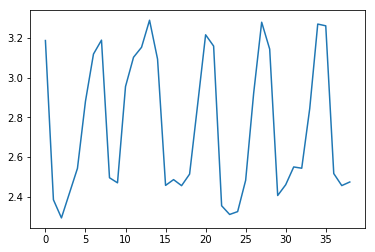

In [28]:
plt.plot(testpreds[129])

In [29]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [30]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.809257   
air_0164b9927d20bcc3_2017-04-23              1.456940   
air_0241aa3964b7f861_2017-04-23              2.400194   
air_0328696196e46f18_2017-04-23              2.229768   
air_034a3d5b40d5b1b1_2017-04-23              3.543189   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.105907  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.292803  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23  10.025310  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   8.297706  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  33.577008

In [31]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [32]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [33]:
submission.to_csv("../submission/l4_3003_conv_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')